# Predictive Analytics  
**Dataset :** 
Combined Cycle Power Plant Data Set, *accessed from* https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant   

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

## Data Loading

In [ ]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip'

--2022-10-11 03:22:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip’

CCPP.zip            100%[===================>]   3.50M  6.77MB/s    in 0.5s    

2022-10-11 03:22:01 (6.77 MB/s) - ‘CCPP.zip’ saved [3674852/3674852]



### Ekstrak Data

In [ ]:
local_zip = 'CCPP.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

## Data Exploration

In [ ]:
df = pd.read_excel('/CCPP/Folds5x2_pp.xlsx')
display(df)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


*Output* kode di atas memberikan informasi sebagai berikut:
* Ada 9568 baris (*records* atau jumlah pengamatan) dalam dataset.
* Terdapat 5 kolom yaitu `AT`, `V`, `AP`, `RH`, `PE`

### Deskripsi Variabel

Berdasarkan informasi dari [UCI](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant), variabel-variabel pada *Cycle Power Plant* Dataset adalah sebagai berikut:
* *Temperature* (T) adalah suhu dengan jangkauan 1,81 sampai 37,11 (dalam derajat *Celcius*)
* *Ambient Pressure* (AP) adalah satuan tekanan dari media di sekitar objek seperti gas atau cairan dengan jangkauan 992,89 sampai 1033,30 milibar.
* *Relative Humidity* (RH) adalah jumlah kadar air (uap air) yang menandakan kemampuan udara untuk menampung uap air dengan jangkauan 25,56 sampai 100,16 (dalam persen %).
* *Exhaust Vacuum* (V) adalah kekuatan dalam menghisap debu maupun membuang udara panas dengan jangkauan 25,36 sampai 81,56 (dalam satuan cmHg).
* *Net hourly electrical energy output* (EP) adalah besarnya daya yang dihasilkan setiap satu jamnya dengan jangkauan 420,26 sampai 495, 76 (dalam satuan MW per jam).


Setelah memahami deskripsi variabel pada data, langkah selanjutnya adalah mengecek informasi pada dataset dengan fungsi info() berikut:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


Dari output terlihat bahwa:
* Semua kolom (fitur) merupakan fitur numerik
* Semua fitur numerik memiliki tipe data yang sama yaitu float64
* Fitur PE merupakan target fitur kita

Dari uraian di atas menunjukkan bahwa setiap kolom telah memiliki tipe data yang sesuai. Selanjutnya kita perlu mengecek deskripsi statistik data dengan fitur describe().

In [ ]:
display(df.describe())

,AT,V,AP,RH,PE
count,9468.000000,9468.00000,9468.000000,9468.000000,9468.000000
mean,19.719883,54.41369,1013.148802,73.322083,454.209298
std,7.427311,12.70141,5.704623,14.551203,17.029285
min,1.810000,25.36000,996.870000,31.150000,420.260000
25%,13.577500,41.74000,1009.090000,63.285000,439.697500
50%,20.500000,52.72000,1012.900000,74.980000,451.210000
75%,25.760000,66.54000,1017.170000,84.840000,468.190000
max,37.110000,81.56000,1029.410000,100.160000,495.760000


Fungsi describe() memberikan informasi statistik pada masing-masing kolom, antara lain:
* *Count* adalah jumlah sample pada data.
* *Mean* adalah nilai rata-rata
* *Std* adalah standar deviasi
* *Min* yaitu nilai minimum setiap kolom
* *25%* adalah kuartil pertama. Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
* *50%* adalah kuartil kedua, atau biasa juga disebut median (nilai tengah).
* *75%* adalah kuartil ketiga.
* *Max* adalah nilai maksimum.

### Menangani Missing Value

Mari kita cek ada berapa missing value (NULL, NaN) pada semua kolom.

In [ ]:
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

Dari *output* isnull().sum() terlihat bahwa setiap fitur tidak memiliki nilai NULL maupun NAN sehingga sekarang kita bisa lanjutkan ke tahapan selanjutnya yaitu menangani *outliers*.

### Menangani Outliers

Pada kasus ini, kita akan mendeteksi *outliers* dengan teknis visualisasi data (boxplot). Kemudian kita akan menangani *outliers* dengan metode IQR.

Sekarang, mari kita lakukan visualisasi pada fitur numerik.

#### 1. Fitur AT

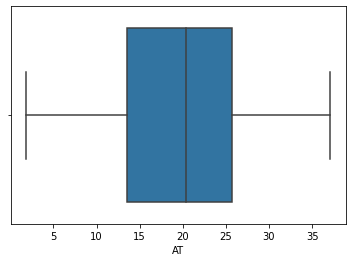

In [ ]:
sns.boxplot(x=df['AT'])

#### 2. Fitur V

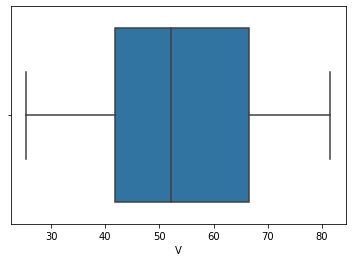

In [ ]:
sns.boxplot(x=df['V'])

#### 3. Fitur AP

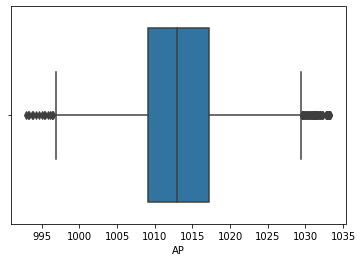

In [ ]:
sns.boxplot(x=df['AP'])

#### 4. Fitur RH

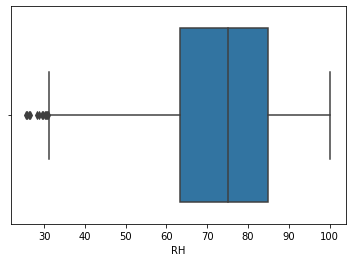

In [ ]:
sns.boxplot(x=df['RH'])

#### 5. Fitur PE (Target)

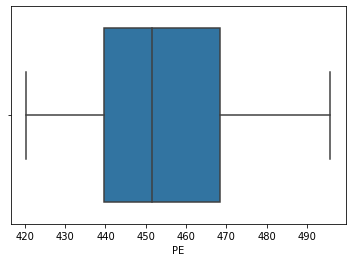

In [ ]:
sns.boxplot(x=df['PE'])

Jika kita perhatikan kembali, pada beberapa fitur numerik di atas terdapat *outliers* (fitur `AP` dan `RH`). Kita akan menggunakan metode IQR untuk mengidentifikasi *outlier* yang berada di luar Q1 dan Q3. Nilai apa pun yang berada di luar batas ini dianggap sebagai *outlier*.

Seltman dalam “*Experimental Design and Analysis*” [[1]](https://www.stat.cmu.edu/~hseltman/309/Book/Book.pdf) menyatakan bahwa *outliers* yang diidentifikasi oleh boxplot (disebut juga “boxplot *outliers*”) didefinisikan sebagai data yang nilainya 1.5 IQR di atas Q3 atau 1.5 IQR di bawah Q1.

Berikut persamaannya:
```
Batas bawah = Q1 - 1.5 * IQR
Batas atas = Q3 + 1.5 * IQR
```
Mari kita terapkan ke dalam kode

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

print(f"Sebelum proses menghilangkan outlier, ukuran dataset adalah {df.shape}")
# Proses menghilangkan outlier
df = df[
    ~((df < batas_bawah) | (df > batas_atas)).any(axis=1)
]

# Cek ukuran dataset setelah kita hilangkan outlier
print(f"Setelah proses menghilangkan outlier, ukuran dataset adalah {df.shape}")

Sebelum proses menghilangkan outlier, ukuran dataset adalah (9568, 5)
Setelah proses menghilangkan outlier, ukuran dataset adalah (9468, 5)


Banyak *outlier* yang dibersihkan sebanyak 9568 - 9468 = 100 (baris atau sampel). Kita akan cek kembali dengan boxplot setelah membersihkan *outlier*.

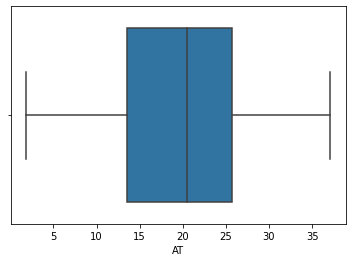

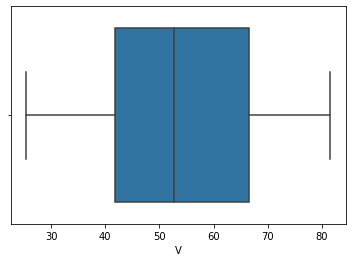

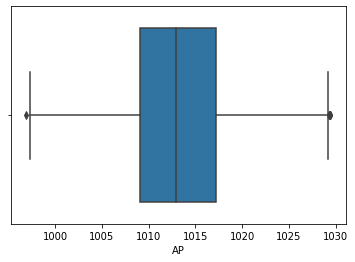

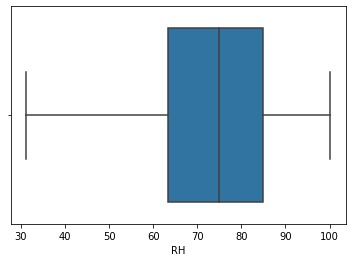

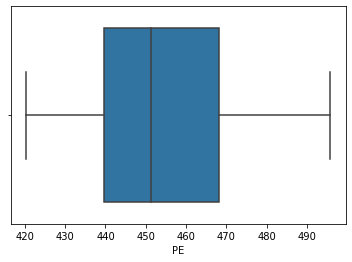

In [ ]:
for fitur in df.keys():
  sns.boxplot(x=df[fitur])
  plt.show()

Dari hasil deteksi ulang *outlier* dengan boxplot di atas, didapat bahwa *outlier* sudah berkurang setelah dibersihkan.

### Univariate Analysis
Selanjutnya, kita akan melakukan proses analisis data dengan teknik Univariate EDA. Pada kasus ini semua fiturnya adalah fitur numerik dan tidak ada fitur kategorikal. Sehingga kita hanya perlu lakukan analisa terhadap fitur numerik sebagai berikut:

#### Analisa Fitur Numerik
Kita akan melihat histogram masing-masing fitur menggunakan kode berikut

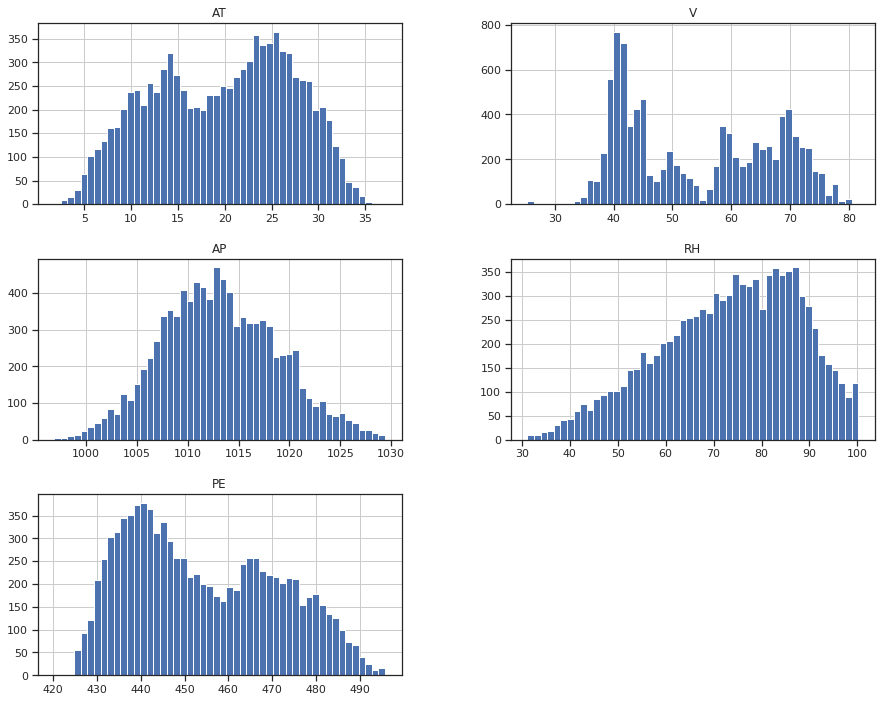

In [ ]:
sns.set(style="ticks", color_codes=True)
df.hist(bins=50, figsize=(15, 12))
plt.show()

Dari hasil visualisasi histogram di atas, kita bisa memperoleh beberapa informasi, antara lain:
* Distribusi fitur PE (target) cenderung miring ke kanan (*right-skewed*).
* Distibusi fitur RH cenderung miring ke kiri (*left-skewed*).

Karena beberapa fitur belum terdistribusi normal hal ini akan berimplikasi pada model, maka selanjutnya kita lakukan transformasi data (*non-linear scaling*). Namun, sebelum itu kita cek terlebih dahulu hubungan antara fitur numerik tersebut.

### Multivariate Analysis

#### Hubungan antara Fitur Numerik
Untuk mengamati hubungan antara fitur numerik, kita akan menggunakan fungsi pairplot().

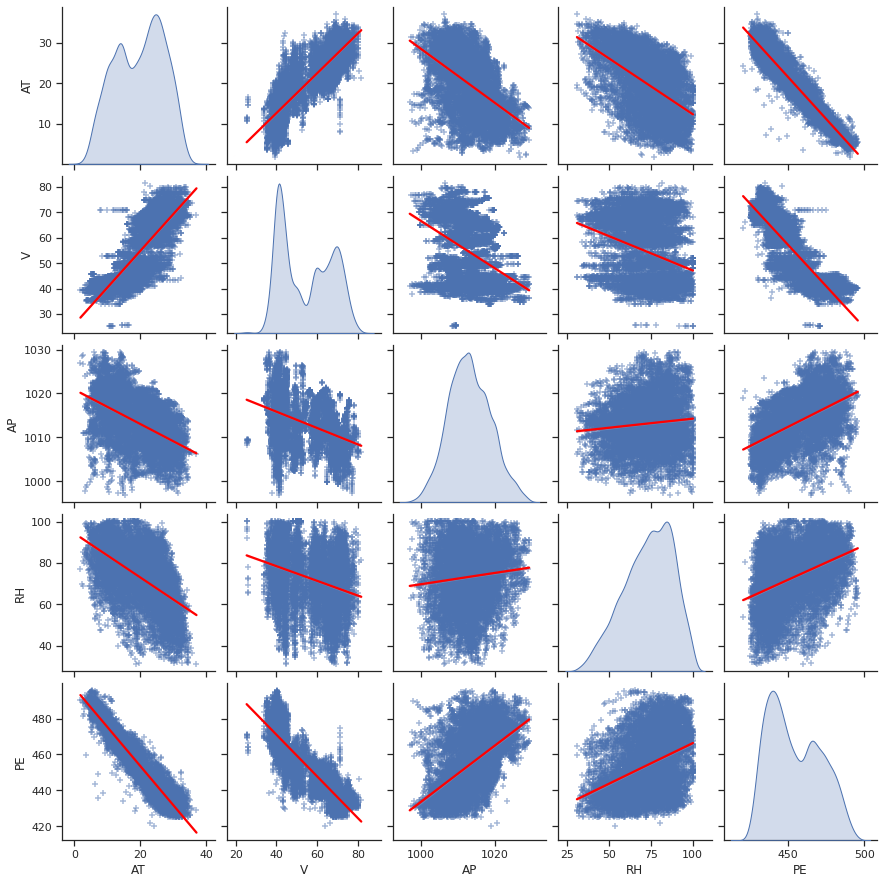

In [ ]:
# Mengamati hubungan antar fitur numerik dengan fungsi pairplot()
sns.set(style="ticks", color_codes=True)
sns.pairplot(df,
             kind="reg",
             markers="+",
             diag_kind='kde',
             plot_kws={'line_kws': {'color':'red'},
                       'scatter_kws': {'alpha': 0.5}})

Pada pola sebaran data grafik pairplot di atas, terlihat fitur `AT` dan `V` memiliki korelasi kuat (negatif / berkebalikan) dengan fitur `PE` (target). Sedangkan kedua fitur lainnya yaitu `AP` dan `RH` memiliki korelasi positif yang lemah dengan fitur `PE`. Untuk mengevaluasi skor korelasinya, kita akan gunakan fungsi corr() sebagai berikut

#### Korelasi antara Fitur Numerik

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

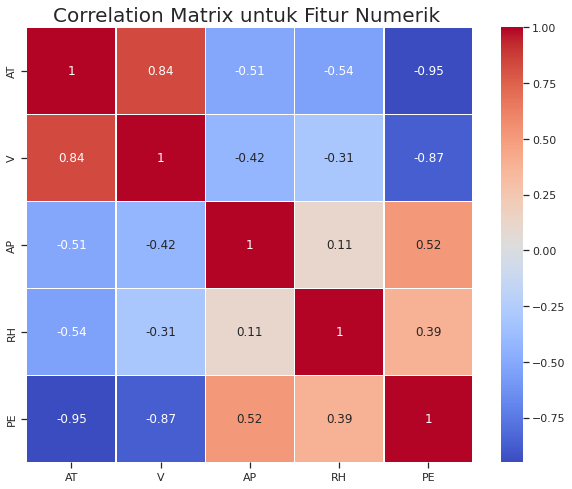

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr().round(2)

# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Koefisien korelasi berkisar antara -1 dan +1. Semakin dekat nilainya ke 1 atau -1, maka korelasinya semakin kuat. Sedangkan, semakin dekat nilainya ke 0 maka korelasinya semakin lemah.

Dari grafik korelasi di atas, fitur `AT` dan `V` memiliki korelasi yang kuat (mendekati -1, dibawah -0.85) dengan fitur target `PE`. Sementara itu, fitur `AP` dan `RH` mempunyai korelasi yang rendah dengan fitur target `PE`.

## Data Preparation

### Train Test Split

Kita akan membagi dataset menjadi data latih (*train*) dan data uji (*test*). Tujuan langkah ini sebelum proses lainnya adalah agar kita tidak mengotori data uji dengan informasi yang kita dapat dari data latih. Contoh pada proses standarisasi dimana jika belum di bagi menjadi data latih dan uji, maka keduanya akan terkena transformasi data yang menggunakan informasi (*mean* dan *standard deviation*) dari gabungan data latih dan uji. Hal ini berpotensi menimbulkan kebocoran data (*data leakage*). Oleh karena itu langkah awal sebelum melakukan tranformasi data adalah membagi dataset terlebih dahulu [[2] (hal. 129)](https://learning.oreilly.com/library/view/hands-on-predictive-analytics/9781789138719/).

Pada kasus ini kita akan menggunakan proporsi pembagian sebesar 90:10 dengan fungsi train_test_split dari sklearn.

In [ ]:
from sklearn.model_selection import train_test_split
 
X = df.drop(["PE"], axis =1)
y = df["PE"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123)

# Cek hasil pembagian dataset
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 9468
Total # of sample in train dataset: 8521
Total # of sample in test dataset: 947


### Standarisasi
Proses standarisasi bertujuan untuk membuat fitur data menjadi bentuk yang lebih mudah diolah oleh algoritma. Kita akan menggunakan teknik StandarScaler dari *library* Scikitlearn.

StandardScaler melakukan proses standarisasi fitur dengan mengurangkan *mean* kemudian membaginya dengan standar deviasi untuk menggeser distribusi. StandarScaler menghasilkan distribusi deviasi sama dengan 1 dan *mean* sama dengan 0.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.keys())
display(X_train_scaled.describe().round(4))

,AT,V,AP,RH
count,8521.0000,8521.0000,8521.0000,8521.0000
mean,-0.0000,-0.0000,0.0000,-0.0000
std,1.0001,1.0001,1.0001,1.0001
min,-2.4059,-2.2844,-2.8439,-2.9015
25%,-0.8254,-0.9953,-0.7095,-0.6870
50%,0.0973,-0.1595,-0.0423,0.1132
75%,0.8129,0.9565,0.7000,0.7904
max,2.3422,2.1385,2.8396,1.8386


### Non-linear Scaling
Mengingat kembali terkait hasil visualisasi histogram setiap fitur sebelumnya, terlihat bahwa beberapa fitur belum terdistribusi normal antara lain fitur `PE` (*right-skewed*) dan fitur `RH` (*left-skewed*). Sehingga kita bisa lakukan proses *non-linear scaling*. Pada kasus ini kita akan gunakan metode `Yeo-Johnson` karena dapat menangani data negatif setelah proses standarisasi.

Mengingat fitur `PE` adalah target fitur, maka kita akan mengecualikannya dalam proses ini agar distribusinya tetap dipertahankan sesuai data aslinya.

In [ ]:
X_train_scaled_temp = X_train_scaled.copy()
list_name_ori_fitur = X_train_scaled_temp.keys()

# Standardize=false karena sudah kita lakukan standarisasi sebelumnya
yj_scaler = PowerTransformer(method='yeo-johnson', standardize=False)
yj_df = pd.DataFrame(
    yj_scaler.fit_transform(X_train_scaled_temp),
    columns=list_name_ori_fitur)

for fitur in list_name_ori_fitur:
  X_train_scaled['YJ_' + fitur] = yj_df[fitur]

Cek histogram untuk distribusi data pada setiap fitur setelah dilakukan *non-linear scaling* dengan metode `Yeo-Johnson`.

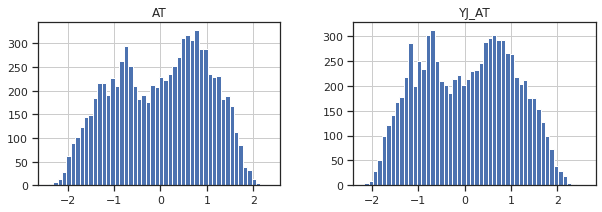

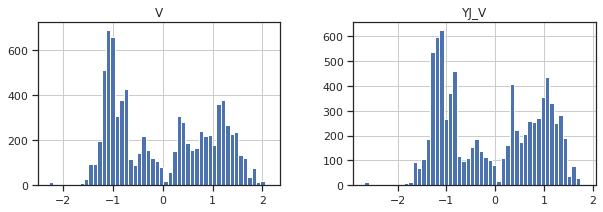

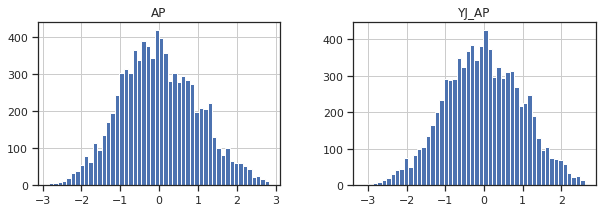

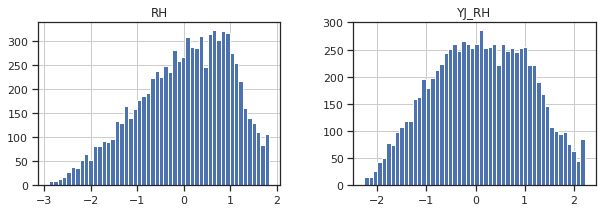

In [ ]:
sns.set(style="ticks", color_codes=True)
for fitur in list_name_ori_fitur:
  X_train_scaled[[fitur,"YJ_" + fitur]].hist(bins=50, figsize=(10, 3))
plt.show()

Selanjutnya kita *drop* `AT`, `V`, `AP`, `RH` karena sudah tergantikan dengan `YJ_AT`, `YJ_V`, `YJ_AP`, `YJ_RH` yang lebih mendekati distribusi normal.

In [ ]:
X_train_scaled.drop(['AT', 'V', 'AP', 'RH'], axis=1, inplace=True)
display(X_train_scaled.head())

,YJ_AT,YJ_V,YJ_AP,YJ_RH
0,-0.935750,-0.130613,2.089722,-0.307734
1,1.336847,0.760638,0.754588,-1.647642
2,0.727460,0.724802,0.064009,-0.556362
3,-0.635213,-0.660453,-1.036064,1.512621
4,0.327177,-1.145919,-2.048456,-1.529602


### Reduksi Dimensi dengan PCA

PCA umumnya digunakan ketika variabel dalam data yang memiliki korelasi yang tinggi. Korelasi tinggi ini menunjukkan data yang berulang atau *redundant*. Sebelumnya kita perlu cek kembali korelasi antar fitur dengan menggunakan pairplot.

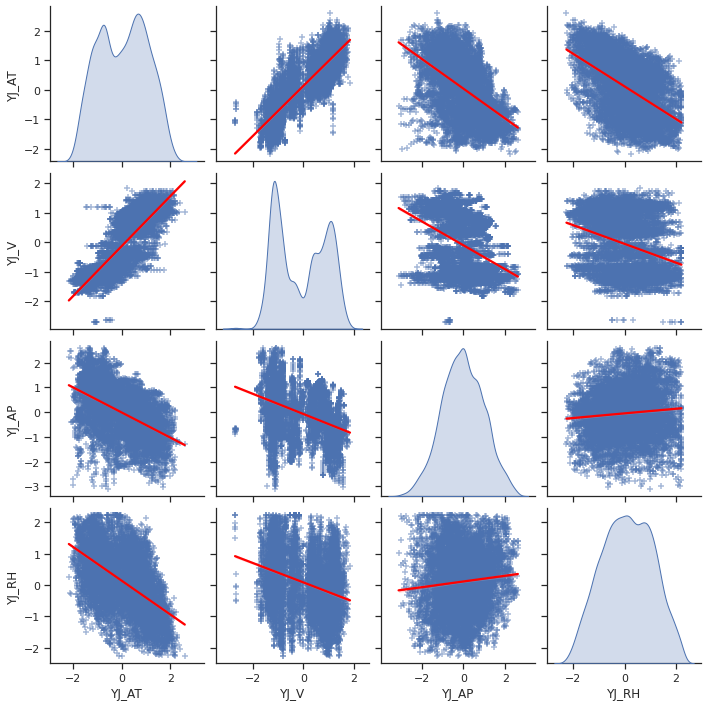

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(X_train_scaled[['YJ_AT', 'YJ_V', 'YJ_AP', 'YJ_RH']],
             kind="reg",
             markers="+",
             diag_kind='kde',
             plot_kws={'line_kws': {'color':'red'},
                       'scatter_kws': {'alpha': 0.5}})

Selanjutnya kita akan mereduksi `YJ_AT` dan `YJ_V` karena keduanya berkorelasi kuat yang dapat dilihat pada visualisasi pairplot di atas.

In [ ]:
pca = PCA(n_components=2, random_state=123)
pca.fit(X_train_scaled[['YJ_AT', 'YJ_V']])
princ_comp = pca.transform(X_train_scaled[['YJ_AT', 'YJ_V']])

Setelah menerapkan class PCA dengan n_components sebanyak fitur yang dikenakan PCA, kita bisa mengetahui proporsi informasi dari kedua komponen hasil PCA sebagai berikut:

In [ ]:
pca.explained_variance_ratio_.round(3)

array([0.925, 0.075])

Arti dari *output* di atas adalah, 92.5% informasi pada kedua fitur `YJ_AT` dan `YJ_V` terdapat pada PC (*Principal Component*) pertama. Sedangkan sisanya sebesar 7.5% terdapat pada PC kedua.

Berdasarkan hasil tersebut, kita akan mereduksi fitur dan hanya mempertahankan PC (komponen) pertama saja. PC pertama ini akan menjadi fitur yang menggantikan dua fitur lainnya (`YJ_AT` dan `YJ_V`). Kita beri nama fitur ini `PC_ATV` (*Principal Component* AT & V).

In [ ]:
pca = PCA(n_components=1, random_state=123)
pca.fit(X_train_scaled[['YJ_AT', 'YJ_V']])
X_train_scaled['PC_ATV'] = pca.transform(X_train_scaled.loc[:, ('YJ_AT', 'YJ_V')]).flatten()
X_train_scaled.drop(['YJ_AT', 'YJ_V'], axis=1, inplace=True)
display(X_train_scaled.sample(5))

,YJ_AP,YJ_RH,PC_ATV
6697,0.489467,0.281716,-0.668645
3735,2.049647,1.627538,-1.298155
52,0.110746,1.318874,0.339899
5419,-0.061729,1.538340,0.730265
5523,0.158992,-0.439972,1.271907


### Transformasi Data Uji
Sebelumnya, kita baru melakukan proses transformasi data (standarisasi dan *non-linear scaling*) pada data latih untuk menghindari kebocoran data. Sekarang, setelah data latih kita transformasikan secara independen dan diamankan ke dalam variable `X_train_scaled`, selanjutnya kita perlu melakukan proses transformasi data terhadap data uji dengan `scaler` dari proses standarisasi, `yj_scaler` dari proses *non-linear scaling* (metode `yeo-johnson`) dan proses pca untuk digunakan pada proses evaluasi model.
Biasanya proses ini dilakukan setelah proses *training* model, namun kita lakukan sekarang dengan tujuan supaya dapat digunakan untuk mencari nilai k optimum pada model KNN (bagian selanjutnya).

In [ ]:
# Scaling terhadap proses standarisasi pada data uji
X_test_standardize = scaler.transform(X_test)

# Scaling terhadap proses non-linear scaling (metode yeo-johnson) pada data uji
# dan menyimpan kembali dalam format DataFrame
X_test_scaled = pd.DataFrame(
    yj_scaler.transform(X_test_standardize),
    columns=["YJ_" + fitur for fitur in list_name_ori_fitur])

# Transformasi data dengan PCA
X_test_scaled["PC_ATV"] = pca.transform(X_test_scaled.loc[:, ('YJ_AT', 'YJ_V')]).flatten()

# Drop fitur lama yang tergantikan dengan komponen baru hasil PCA
X_test_scaled.drop(['YJ_AT', 'YJ_V'], axis=1, inplace=True)

# Cek hasil scaling
display(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"


,YJ_AP,YJ_RH,PC_ATV
0,-0.280138,1.048203,0.682992
1,-0.044167,0.784226,-1.763109
2,-1.100085,-0.907001,0.864835
3,1.495946,0.510210,-1.958569
4,0.398838,0.552927,-1.802959
...,...,...,...
942,-0.362872,-0.638957,1.633829
943,0.041428,0.444081,0.903385
944,0.937499,-0.295727,-1.636853
945,-0.112832,-1.697139,2.267231


## Model Development
Pada tahap ini, kita akan menggunakan tiga algoritma untuk kasus regresi ini. Kemudian, kita akan mengevaluasi performa masing-masing algoritma dan menetukan algoritma mana yang memberikan hasil prediksi terbaik. Ketiga algoritma yang akan kita gunakan, antara lain:
1. K-Nearest Neighbor

  Kelebihan algoritma KNN adalah mudah dipahami dan digunakan sedangkan kekurangannya kika dihadapkan pada jumlah fitur atau dimensi yang besar rawan terjadi bias.

2. Random Forest

  Kelebihan algoritma Random Forest adalah menggunakan teknik Bagging yang berusaha melawan *overfitting* dengan berjalan secara paralel. Sedangkan kekurangannya ada pada kompleksitas algoritma Random Forest yang membutuhkan waktu relatif lebih lama dan daya komputasi yang lebih tinggi dibanding algoritma seperti Decision Tree. 

3. Boosting Algorithm

  Kelebihan algoritma Boosting adalah menggunakan teknik Boosting yang berusaha menurunkan bias dengan berjalan secara sekuensial (memperbaiki model di tiap tahapnya). Sedangkan kekurangannya
hampir sama dengan algoritma Random Forest dari segi kompleksitas komputasi yang menjadikan waktu pelatihan relatif lebih lama, selain itu *noisy* dan *outliers* sangat berpengaruh dalam algoritma ini.

Untuk langkah pertama, kita akan siapkan DataFrame baru untuk menampung nilai metrik (MSE - *Mean Squared Error*) pada setiap model / algoritma. Hal ini berguna untuk melakukan analisa perbandingan antar model.

In [ ]:
# Siapkan dataframe untuk analisis model
df_models = pd.DataFrame(index=['Train MSE', 'Test MSE'], 
                      columns=['KNN', 'RandomForest', 'Boosting'])

### Model K-Nearest Neighbor
KNN bekerja dengan membandingkan jarak satu sampel ke sampel pelatihan lain dengan memilih k tetangga terdekat. Pemilihan nilai k sangat penting dan berpengaruh terhadap performa model. Jika kita memilih k yang terlalu rendah, maka akan menghasilkan model yang *overfitting* dan hasil prediksinya memiliki varians tinggi. Jika kita memilih k yang terlalu tinggi, maka model yang dihasilkan akan *underfitting* dan prediksinya memiliki bias yang tinggi [[3] (Hal. 286)](https://learning.oreilly.com/library/view/machine-learning-with/9781617296574/).

Oleh karena itu, kita akan mencoba beberapa nilai k yang berbeda (1 sampai 20) kemudian membandingan mana yang menghasilkan nilai metrik model (pada kasus ini kita pakai *mean squared error*) terbaik. Selain itu, kita akan menggunakan metrik ukuran jarak secara default (*Minkowski Distance*) pada library sklearn.

In [ ]:
list_mse = []
for k in range(1, 21):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  y_prediction = knn.predict(X_test_scaled)
  test_mse = mean_squared_error(y_test, y_prediction)
  list_mse.append(test_mse)
  print(f"Nilai MSE untuk k = {k} adalah : {test_mse}")

Nilai MSE untuk k = 1 adalah : 27.164278458289346
Nilai MSE untuk k = 2 adalah : 21.131600369588185
Nilai MSE untuk k = 3 adalah : 19.491511862020435
Nilai MSE untuk k = 4 adalah : 19.261315192713845
Nilai MSE untuk k = 5 adalah : 18.72220005068637
Nilai MSE untuk k = 6 adalah : 18.880029869177513
Nilai MSE untuk k = 7 adalah : 18.529073128892524
Nilai MSE untuk k = 8 adalah : 18.68825011054647
Nilai MSE untuk k = 9 adalah : 18.636591223747512
Nilai MSE untuk k = 10 adalah : 18.852110728616697
Nilai MSE untuk k = 11 adalah : 18.962034640055155
Nilai MSE untuk k = 12 adalah : 19.011120737269756
Nilai MSE untuk k = 13 adalah : 19.172104390070178
Nilai MSE untuk k = 14 adalah : 19.2599176567248
Nilai MSE untuk k = 15 adalah : 19.383454522585954
Nilai MSE untuk k = 16 adalah : 19.384363042832625
Nilai MSE untuk k = 17 adalah : 19.4375758187392
Nilai MSE untuk k = 18 adalah : 19.6279974950135
Nilai MSE untuk k = 19 adalah : 19.7668103885429
Nilai MSE untuk k = 20 adalah : 19.74753467951425


Dan jika kita coba visualisasikan dengan fungsi plot() dalam DataFrame kita peroleh:

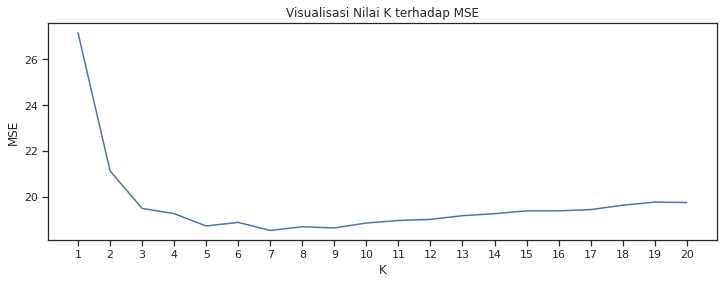

In [ ]:
pd.DataFrame(list_mse, index=range(1, 21)).plot(
    xlabel="K",
    ylabel="MSE",
    legend=False,
    xticks=range(1,21), 
    figsize=(12,4),
    title='Visualisasi Nilai K terhadap MSE')

Dari hasil *output* diatas, nilai MSE terbaik dicapai ketika `k = 7` yaitu sebesar 18.529. Oleh karena itu kita akan menggunakan k = 7 dan menyimpan nilai MSE nya (terhadap data latih, untuk data uji akan dilakukan pada proses evaluasi) kedalam `df_models` yang telah kita siapkan sebelumnya.

In [ ]:
KNN = KNeighborsRegressor(n_neighbors=7)
KNN.fit(X_train_scaled, y_train)
df_models.loc['Train MSE', 'KNN'] = mean_squared_error(
    y_pred=KNN.predict(X_train_scaled),
    y_true=y_train)

### Random Forest
Random forest merupakan algoritma *supervised learning* yang termasuk ke dalam kategori *ensemble* (group) learning. Pada model *ensemble*, setiap model harus membuat prediksi secara independen. Kemudian, prediksi dari setiap model *ensemble* ini digabungkan untuk membuat prediksi akhir. Jenis metode *ensemble* yang digunakan pada Random Forest adalah teknik *Bagging*. Metode ini bekerja dengan membuat *subset* dari data train yang independen. Beberapa model awal (*base model / weak model*) dibuat untuk dijalankan secara simultan / paralel dan independen satu sama lain dengan subset data *train* yang independen. Hasil prediksi setiap model kemudian dikombinasikan untuk menentukan hasil prediksi final.

Kita akan menggunakan `RandomForestRegressor` dari library scikit-learn dengan base_estimator defaultnya yaitu `DecisionTreeRegressor` dan parameter-parameter (*hyperparameter*) yang digunakan antara lain:
- n_estimator: jumlah *trees* (pohon) di *forest*.
- max_depth:  kedalaman atau panjang pohon. Ia merupakan ukuran seberapa banyak pohon dapat membelah (*splitting*) untuk membagi setiap node ke dalam jumlah pengamatan yang diinginkan.
- random_state: digunakan untuk mengontrol random *number generator* yang digunakan.
- n_jobs: jumlah *job* (pekerjaan) yang digunakan secara paralel. Ia merupakan komponen untuk mengontrol *thread* atau proses yang berjalan secara paralel. n_jobs=-1 artinya semua proses berjalan secara paralel.

Untuk menentukan nilai *hyperparameter* (n_estimator & max_depth) di atas, kita akan melakukan tuning dengan `RandomizedSearchCV`.

In [ ]:
params_rf = {
    "n_estimators": np.arange(10, 100, 10), # kelipatan 10 mulai dari 10 sampai 90
    "max_depth": [4, 8, 16, 32]
}

# Randomized search model
rs_model = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=123),
    param_distributions=params_rf,
    # Ref: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scoring='neg_mean_squared_error', # Negatif dari nilai MSE
    verbose=3
)

rs_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ....max_depth=8, n_estimators=20;, score=-19.307 total time=   0.3s
[CV 2/5] END ....max_depth=8, n_estimators=20;, score=-19.019 total time=   0.3s
[CV 3/5] END ....max_depth=8, n_estimators=20;, score=-20.611 total time=   0.3s
[CV 4/5] END ....max_depth=8, n_estimators=20;, score=-21.021 total time=   0.3s
[CV 5/5] END ....max_depth=8, n_estimators=20;, score=-18.206 total time=   0.3s
[CV 1/5] END ....max_depth=8, n_estimators=50;, score=-19.073 total time=   0.6s
[CV 2/5] END ....max_depth=8, n_estimators=50;, score=-18.851 total time=   0.6s
[CV 3/5] END ....max_depth=8, n_estimators=50;, score=-20.390 total time=   0.6s
[CV 4/5] END ....max_depth=8, n_estimators=50;, score=-20.645 total time=   0.6s
[CV 5/5] END ....max_depth=8, n_estimators=50;, score=-18.143 total time=   0.6s
[CV 1/5] END ...max_depth=32, n_estimators=80;, score=-18.890 total time=   1.5s
[CV 2/5] END ...max_depth=32, n_estimators=80;, 

RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=123),
                   param_distributions={'max_depth': [4, 8, 16, 32],
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   scoring='neg_mean_squared_error', verbose=3)

Mengecek hasil tuning hyperparameter dan nilai metrik MSE.

In [ ]:
print("Hasil tuning hyperparameter", rs_model.best_params_)

print("Nilai MSE model RandomSearchCV_RF dengan data latih", mean_squared_error(
    y_pred=rs_model.predict(X_train_scaled),
    y_true=y_train))
print("Nilai MSE model RandomSearchCV_RF dengan data uji", mean_squared_error(
    y_pred=rs_model.predict(X_test_scaled),
    y_true=y_test))

Hasil tuning hyperparameter {'n_estimators': 80, 'max_depth': 32}
Nilai MSE model RandomSearchCV_RF dengan data latih 2.592137498639827
Nilai MSE model RandomSearchCV_RF dengan data uji 17.254006379841524


Dari hasil *output* di atas diperoleh nilai MSE terbaik dalam jangkauan parameter `params_rf` yaitu 2.592 (dengan data *train*) dan 17.254 (dengan data *test*) dengan `n_estimators`: 80 dan `max_depth`: 32. Selanjutnya kita akan menggunakan pengaturan parameter tersebut dan menyimpan nilai MSE nya kedalam `df_models` yang telah kita siapkan sebelumnya.

In [ ]:
RF = RandomForestRegressor(n_estimators=80, max_depth=32)
RF.fit(X_train_scaled, y_train)

df_models.loc['Train MSE', 'RandomForest'] = mean_squared_error(
    y_pred=RF.predict(X_train_scaled),
    y_true=y_train)

### Boosting Algorithm

Jika sebelumnya kita menggunakan algoritma *bagging* (Random Forest). Selanjutnya kita akan menggunakan metode lain dalam model *ensemble* yaitu teknik Boosting. Algoritma Boosting bekerja dengan membangun model dari data *train*. Kemudian membuat model kedua yang bertugas memperbaiki kesalahan dari model pertama. Model ditambahkan sampai data latih terprediksi dengan baik atau telah mencapai jumlah maksimum model untuk ditambahkan. Teknik ini bekerja secara sekuensial.

Pada kasus ini kita akan menggunakan metode Adaptive Boosting. Untuk implementasinya kita menggunakan `AdaBoostRegressor` dari library sklearn dengan base_estimator defaultnya yaitu `DecisionTreeRegressor` hampir sama dengan `RandomForestRegressor` bedanya menggunakan metode teknik Boosting.

Parameter-parameter (*hyperparameter*) yang digunakan pada algoritma ini antara lain:
* n_estimator: jumlah *estimator* dan ketika mencapai nilai jumlah tersebut algoritma Boosting akan dihentikan.
* learning_rate: bobot yang diterapkan pada setiap *regressor* di masing-masing iterasi Boosting.
* random_state: digunakan untuk mengontrol *random number generator* yang digunakan.

Untuk menentukan nilai *hyperparameter* (n_estimator & learning_rate) di atas, kita akan melakukan *tuning* dengan `RandomizedSearchCV`.

In [ ]:
params_ab = {
    "n_estimators": np.arange(10, 100, 10), # kelipatan 10 mulai dari 10 sampai 90
    "learning_rate": [0.001, 0.01, 0.1, 0.2]
}

# Randomized search model
rs_model_ab = RandomizedSearchCV(
    AdaBoostRegressor(random_state=123),
    param_distributions=params_ab,
    # Ref: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scoring='neg_mean_squared_error', # Negatif dari nilai MSE
    verbose=3
)

rs_model_ab.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.1, n_estimators=10;, score=-27.169 total time=   0.1s
[CV 2/5] END learning_rate=0.1, n_estimators=10;, score=-28.068 total time=   0.1s
[CV 3/5] END learning_rate=0.1, n_estimators=10;, score=-28.106 total time=   0.1s
[CV 4/5] END learning_rate=0.1, n_estimators=10;, score=-28.417 total time=   0.1s
[CV 5/5] END learning_rate=0.1, n_estimators=10;, score=-26.309 total time=   0.1s
[CV 1/5] END learning_rate=0.001, n_estimators=70;, score=-27.929 total time=   0.8s
[CV 2/5] END learning_rate=0.001, n_estimators=70;, score=-28.306 total time=   0.8s
[CV 3/5] END learning_rate=0.001, n_estimators=70;, score=-27.933 total time=   0.8s
[CV 4/5] END learning_rate=0.001, n_estimators=70;, score=-28.860 total time=   0.7s
[CV 5/5] END learning_rate=0.001, n_estimators=70;, score=-26.730 total time=   0.7s
[CV 1/5] END learning_rate=0.2, n_estimators=50;, score=-28.622 total time=   0.5s
[CV 2/5] END lea

RandomizedSearchCV(estimator=AdaBoostRegressor(random_state=123),
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   scoring='neg_mean_squared_error', verbose=3)

Mengecek hasil tuning hyperparameter dan nilai metrik MSE.

In [ ]:
print("Hasil tuning hyperparameter", rs_model_ab.best_params_)

# AB = AdaBoosting
print("Nilai MSE model RandomSearchCV_AB dengan data latih", mean_squared_error(
    y_pred=rs_model_ab.predict(X_train_scaled),
    y_true=y_train))
print("Nilai MSE model RandomSearchCV_AB dengan data uji", mean_squared_error(
    y_pred=rs_model_ab.predict(X_test_scaled),
    y_true=y_test))

Hasil tuning hyperparameter {'n_estimators': 20, 'learning_rate': 0.2}
Nilai MSE model RandomSearchCV_AB dengan data latih 25.319184456840937
Nilai MSE model RandomSearchCV_AB dengan data uji 24.775647647800028


Dari hasil *output* di atas diperoleh nilai MSE terbaik dalam jangkauan parameter `params_ab` yaitu 25.319 (dengan data *train*) dan 24.775 (dengan data *test*) dengan `n_estimators`: 20 dan `learning_rate`: 0.2. Selanjutnya kita akan menggunakan pengaturan parameter tersebut dan menyimpan nilai MSE nya kedalam `df_models` yang telah kita siapkan sebelumnya.

In [ ]:
boosting = AdaBoostRegressor(n_estimators=20, learning_rate=0.2)
boosting.fit(X_train_scaled, y_train)

df_models.loc['Train MSE', 'Boosting'] = mean_squared_error(
    y_pred=boosting.predict(X_train_scaled),
    y_true=y_train)

## Evaluasi Model
Dari proses sebelumnya, kita telah membuat tiga model yang berbeda dan juga telah melatihnya. Selanjutnya kita perlu mengevaluasi model-model tersebut menggunakan data uji dan metrik yang digunakan dalam kasus ini yaitu `mean_squared_error`. Hasil evaluasi kemudian kita simpan ke dalam `df_models`.

In [ ]:
for name, model in {'KNN': KNN, 'RandomForest': RF, 'Boosting': boosting}.items():
  df_models.loc['Test MSE', name] = mean_squared_error(
      y_pred=model.predict(X_test_scaled),
      y_true=y_test)
  
# Mengecek evaluasi model
display(df_models)

,KNN,RandomForest,Boosting
Train MSE,14.032666,2.61751,25.552998
Test MSE,18.529073,17.757302,25.28377


Untuk memudahkan, mari kita plot hasil evaluasi model dengan bar chart.

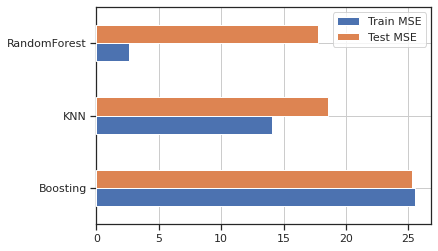

In [ ]:
fig, ax = plt.subplots()
df_models.T.sort_values(by='Test MSE', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

Dari gambar di atas, terlihat bahwa, model RandomForest memberikan nilai eror (MSE) yang paling kecil. Sedangkan model algoritma Boosting memiliki eror yang paling besar. Sebelum memutuskan model terbaik untuk melakukan prediksi *Net hourly electrical energy output* (EP) atau besarnya daya yang dihasilkan setiap satu jam. Mari kita coba uji prediksi menggunakan beberapa sampel acak (5) pada data uji.

In [ ]:
dict_result = {
    'index_sample': [],
    'y_true': [],
    'prediksi_KNN': [],
    'prediksi_RF': [],
    'prediksi_Boosting': []
}

X_sample = X_test_scaled.sample(5)
dict_result['index_sample'] = X_sample.index.values
dict_result['y_true'] = [y_test.iloc[idx] for idx in dict_result['index_sample']]

for name, model in {'KNN': KNN, 'RF': RF, 'Boosting': boosting}.items():
  dict_result['prediksi_' + name] = model.predict(X_sample)

display(pd.DataFrame(dict_result).set_index('index_sample'))

,y_true,prediksi_KNN,prediksi_RF,prediksi_Boosting
index_sample,,,,
778,448.71,444.512857,445.660375,445.046823
844,443.91,440.494286,443.087750,441.048579
41,479.48,476.290000,478.694125,475.847589
162,435.53,434.881429,435.580250,440.357165
863,434.57,438.380000,436.956875,437.679482


Terlihat bahwa prediksi dengan Random Forest (RF) memberikan hasil yang paling mendekati.

## Kesimpulan

Berdasarkan hasil evaluasi model di atas, dapat kita simpulkan bahwa model terbaik untuk melakukan prediksi *Net hourly electrical energy output* (EP) atau besarnya daya yang dihasilkan setiap satu jam adalah model Random Forest. Dengan pengaturan parameter 'n_estimators': 80, 'max_depth': 32 diperoleh nilai metrik MSE sebesar 2.617 (pada data latih) dan 17.757 (pada data uji).

## Daftar Referensi
[1] Seltman, Howard J. “Experimental Design and Analysis”. 2018. Tersedia: [tautan](https://www.stat.cmu.edu/~hseltman/309/Book/Book.pdf). Diakses pada Oktober 2022.  
[2] Fuentes, Alvaro. "Hands-on Predictive Analytics with Python". Packt Publishing. 2018. Tersedia: [O'Reilly Media](https://learning.oreilly.com/library/view/hands-on-predictive-analytics/9781789138719/).  
[3] Rhys, Hefin. "Machine Learning with R, the Tidyverse, and MLR". Manning Publications. 2020. Tersedia: [O'Reilly Media](https://learning.oreilly.com/library/view/machine-learning-with/9781617296574/).

## Data Author
* Moch Galang Rivaldo
* m******@gmail.com